In [92]:
import pandas as pd
import numpy as np
import pymc3 as pm

from sklearn.linear_model import LinearRegression
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
raw = pd.read_csv('./data/exercise.csv').merge(
        pd.read_csv('./data/calories.csv')).drop(['User_ID'], axis=1)
df = raw.copy()

In [3]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'male' else 0).astype(np.uint8)

## Univariate Analysis

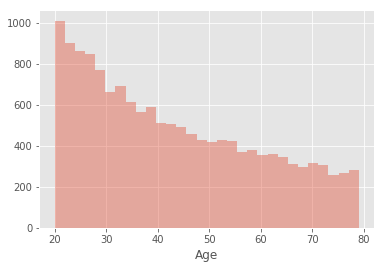

In [4]:
sns.distplot(df['Age'], bins=30, hist=True, norm_hist=False, kde=False)

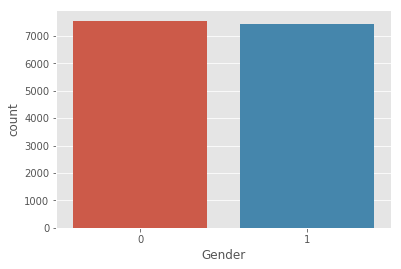

In [5]:
sns.countplot(df['Gender'])

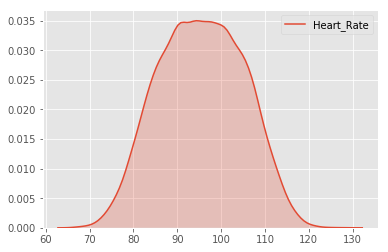

In [6]:
sns.kdeplot(df['Heart_Rate'], shade=True)

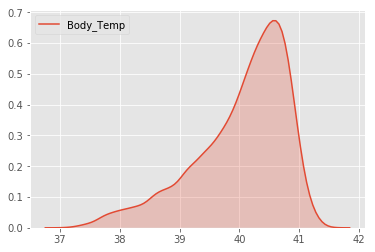

In [7]:
sns.kdeplot(df['Body_Temp'], shade=True)

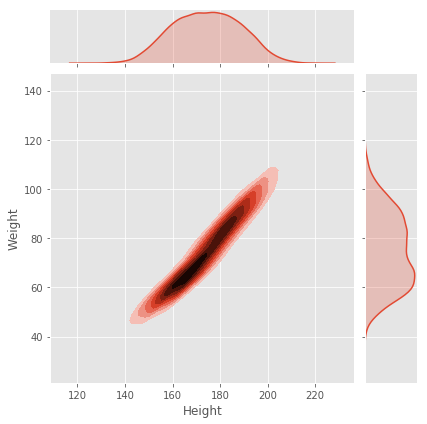

In [8]:
sns.jointplot(x="Height", y="Weight", data=df, kind="kde", shade_lowest=False);

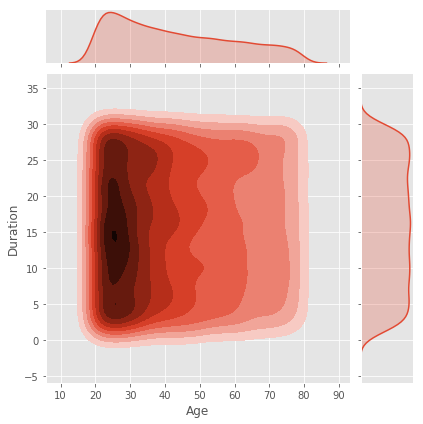

In [9]:
sns.jointplot(x="Age", y="Duration", data=df, kind="kde", shade_lowest=False);

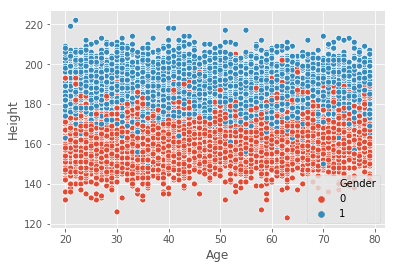

In [10]:
sns.scatterplot(x='Age', y='Height', hue='Gender', data=df)

Text(0.5, 0, 'Duration')

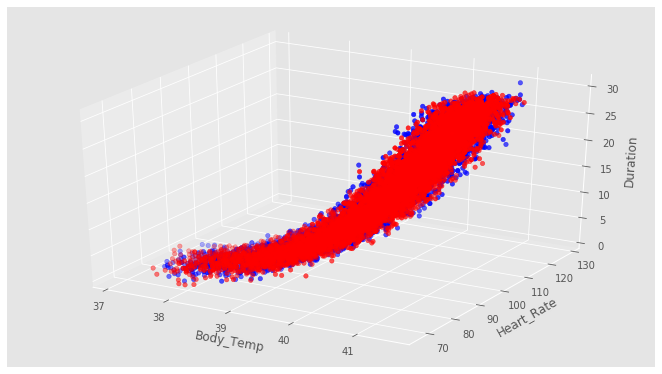

In [11]:
fig = plt.figure(figsize=(9, 5))
ax = Axes3D(fig)
ax.scatter(df.loc[df['Gender'] == 1, 'Body_Temp'], df.loc[df['Gender'] == 1, 'Heart_Rate'], df.loc[df['Gender'] == 1, 'Duration'], color='b')
ax.scatter(df.loc[df['Gender'] == 0, 'Body_Temp'], df.loc[df['Gender'] == 0, 'Heart_Rate'], df.loc[df['Gender'] == 0, 'Duration'], color='red')
ax.set_xlabel('Body_Temp')
ax.set_ylabel('Heart_Rate')
ax.set_zlabel('Duration')

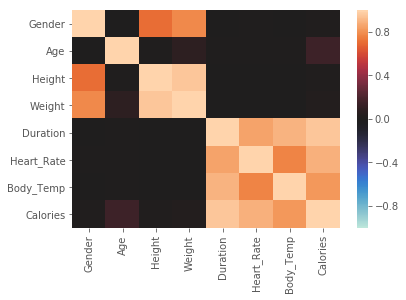

In [12]:
sns.heatmap(df.corr(), cmap='icefire', vmin=-1, vmax=1)

## Modelling

In [500]:
X_train = df.loc[:, df.columns.difference(['Calories', 'Gender'])]
X = df.loc[:200, ['Duration']]
y = df.loc[:200, ['Calories']]

In [501]:
m, n = X.shape

In [502]:
model = pm.Model()

with model:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    θ = pm.Normal('θ', mu=0, sd=10, shape=n)
#     μ = intercept + pm.math.dot(X.values, θ)
    # TODO dot product doesn't seem to work
    μ = intercept
    for k in range(n):
        μ += θ[k] * X.values[:, k].reshape(-1, 1)
    σ = pm.HalfNormal('σ', sd=5)
    y_obs = pm.Normal('yhat', mu=μ, sd=σ, observed=y)

In [507]:
with model:
    sampler = pm.Metropolis()
    trace = pm.sample(3000, tuning=500, step=sampler)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [σ]
>Metropolis: [θ]
>Metropolis: [intercept]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:02<00:00, 3310.66draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1684d1d30>,
      dtype=object)

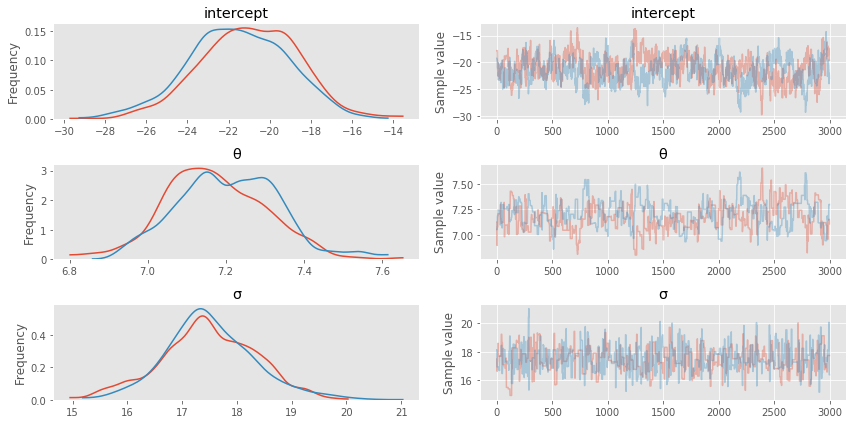

In [508]:
pm.traceplot(trace)

## Posterior Distribution

array([<matplotlib.axes._subplots.AxesSubplot object at 0x16d0e15c0>,
      dtype=object)

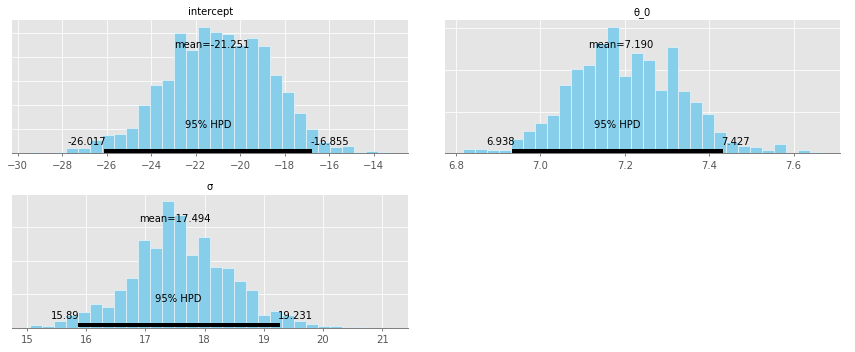

In [509]:
pm.plot_posterior(trace)

## Predictive Posterior Distribution

In [510]:
with model:
    ppc = pm.sample_ppc(trace, samples=300, size=100)

100%|██████████| 300/300 [00:00<00:00, 402.98it/s]


### TODO think about it

In [511]:
ppc['yhat'].mean(axis=1).reshape(300, -1).shape

(300, 201)

In [512]:
# Frequentist OLS
lr = LinearRegression(fit_intercept=True).fit(X, y)
ols_intercept, ols_coef = lr.intercept_, lr.coef_

In [516]:
base = np.linspace(X.min().values, X.max().values, 50)

In [517]:
ols_yhat = (ols_intercept + ols_coef * base).ravel()

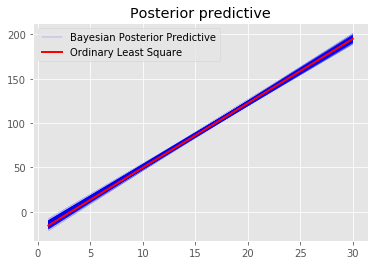

In [518]:
pm.plot_posterior_predictive_glm(trace,
                                 eval=base,
                                 samples=300,
                                 color="b",
                                 label="Bayesian Posterior Predictive",
                                 lm=lambda x_hat, sample: sample['intercept'] + sample['θ'] * x_hat)
plt.plot(base, ols_yhat, color='red', linewidth=2, label='Ordinary Least Square')
plt.legend()

## Uncertainty: Bayesian vs Frequentist Prediction

In [519]:
# randomly pick unseen data
X_test = np.random.randint(-10, 50, 5)

In [520]:
def manual_calculation_yhat(trace, X_test):
    for x in X_test:
        yield trace['intercept'].reshape(-1, 1) + x * trace['θ']

/Users/mingli/.virtualenvs/pp/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


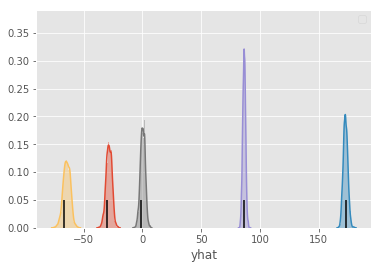

In [521]:
for pp_yhat_dist, ols_yhat in zip(manual_calculation_yhat(trace, X_test), lr.predict(X_test.reshape(-1, 1))):
    sns.distplot(pp_yhat_dist)
    plt.vlines(ols_yhat, ymin=0, ymax=.05)

plt.xlabel('yhat')
plt.legend()